In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pandas as pd
from pathlib import Path
from admanifest.manifest import load_manifest_data

rc('font', family='sans-serif', size=16)
rc('axes', grid=True)
rc('figure', figsize=(16, 8))

In [3]:
def find_datasets(manifest, oname, pname):
    for dataset in manifest.objects['dataset'].values():
        if oname in dataset['objects']:
            for obj in dataset['objects'][oname].values():
                if pname in obj['properties']:
                    yield dataset, obj['properties'][pname]
            
def load_manifest_and_check_errors():
    here = Path('..').resolve()
    manifest = load_manifest_data(here)
    if manifest.errors:
        for error in manifest.errors:
            print(error, file=sys.stderr)
    return manifest

In [4]:
manifest = load_manifest_and_check_errors()

def table():
    for project in manifest.objects['project'].values():
        users = [x['users'] for x in project.get('impact', [])]
        users = mean(users) if users else None
        for obj_name, obj in project['objects'].items():
            for prop_name, prop in obj['properties'].items():
                datasets = list(find_datasets(manifest, obj_name, prop_name))
                datasets = sorted(datasets, key=lambda x: x[1]['stars'])
                if datasets:
                    dataset, dataset_prop = datasets[-1]
                    dataset = {
                        'id': dataset['id'],
                        'stars': dataset_prop['stars'],
                        'provider': dataset['provider'],
                    }
                else:
                    dataset = {'id': None, 'stars': 0, 'provider': None}
                    
                yield {
                    'project': project['id'],
                    'object': obj_name,
                    'property': prop_name,
                    'dataset': dataset['id'],
                    'provider': dataset['provider'],
                    'stars': dataset['stars'],
                    'users': users,
                }
                    
frame = pd.DataFrame(list(table()))
frame.head()

,dataset,object,project,property,provider,stars,users
0,gov/lrs/ad,politika/seimas/seimo_narys,projects/manopozicija.lt,vardas,gov/lrs,3,8.000000
1,gov/lrs/ad,politika/seimas/seimo_narys,projects/manopozicija.lt,pavardė,gov/lrs,3,8.000000
2,gov/lrs/ad,politika/seimas/kadencija,projects/manoseimas.lt,pavadinimas,gov/lrs,3,19607.285714
3,gov/lrs/ad,politika/seimas/kadencija,projects/manoseimas.lt,nuo,gov/lrs,3,19607.285714
4,gov/lrs/ad,politika/seimas/kadencija,projects/manoseimas.lt,iki,gov/lrs,3,19607.285714


## Vidutinis projektams prieinamų duomenų brandos lygis

Vidutinis brandos lygis apskaičiuojamas surandant duomenų tiekėją teikiantį duomenis aukščiausiu brandos lygiu ir paskaičiuojant visų laukų brandos lygio vidurkį.

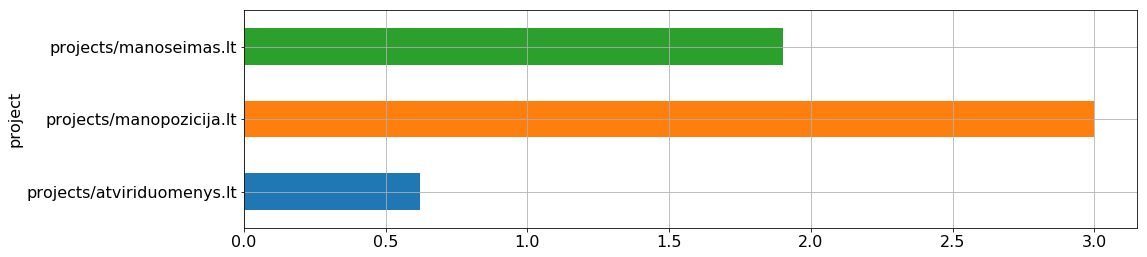

In [5]:
frame.groupby('project').stars.mean().plot.barh(figsize=(16, 4));

## Projektai pagal vidutinį naudotojų skaičių

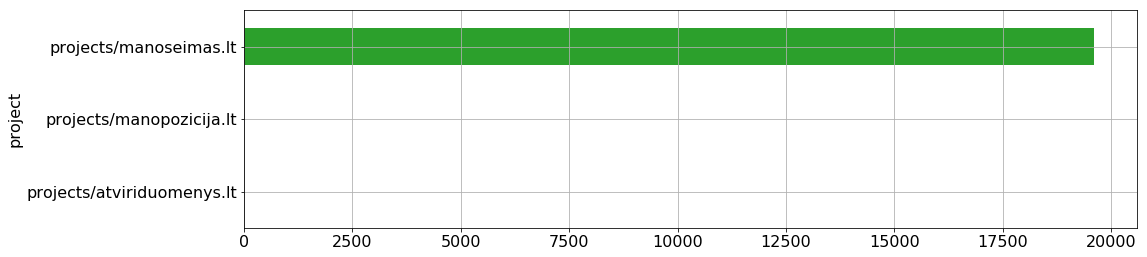

In [6]:
frame.groupby('project').users.first().plot.barh(figsize=(16, 4));

## Prioritetinių duomenų rinkinių sąrašas

Prioritetinių duomenų rinkinių sąrašas apskaičiuotas imant duomenų brandos lygio vidurkį visų laukų, kurie reikalingi projektams ir tą duomenų rinkinį naudojančių bendra projekto naudotojų sumą. Galutiniai rezultatai surūšiuoti pagal brandos lygi didėjančia tvarka ir pagal projektų naudotojų skaičių mažėjančia tvarka.

In [7]:
f = frame.dropna(subset=['dataset']).groupby(['dataset', 'project']).agg({
    'stars': ['sum', 'count'],
    'users': 'first',
}).groupby(level=0).agg({
    ('stars', 'sum'): 'sum',
    ('stars', 'count'): 'sum',
    ('users', 'first'): 'sum',
})
pd.DataFrame({
    'stars': f[('stars', 'sum')] / f[('stars', 'count')],
    'users': f[('users', 'first')],
}).sort_values(['stars', 'users'], ascending=[True, False])

,stars,users
dataset,,
gov/ivpk/opendata.gov.lt,0.642857,0.000000
gov/lrs/ad,2.407407,19615.285714


## Duomenų rinkiniai pagal brandos lygį

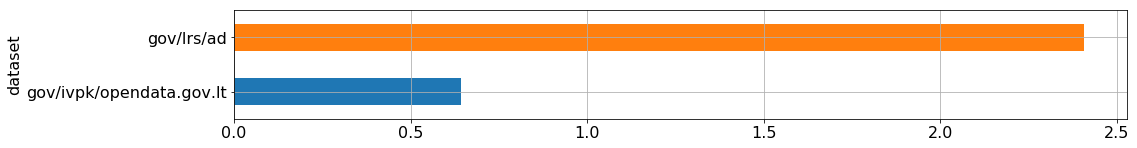

In [8]:
frame.dropna(subset=['dataset']).groupby('dataset').stars.mean().plot.barh(figsize=(16, 2));

## Duomenų tiekėjai pagal projektams reikalingų duomenų laukų skaičių

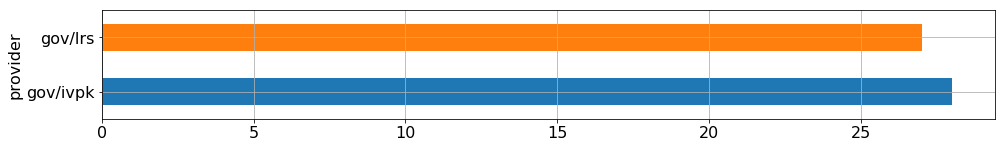

In [9]:
frame.dropna(subset=['provider']).groupby('provider').property.count().plot.barh(figsize=(16, 2));

## Duomenų tiekėjai pagal duomenų brandos lygį

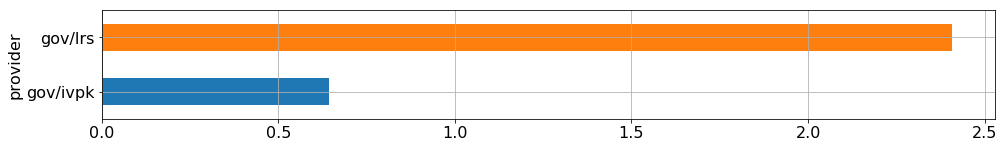

In [10]:
frame.dropna(subset=['provider']).groupby('provider').stars.mean().plot.barh(figsize=(16, 2));